In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import integrate, signal, stats, fftpack, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load Zap_Zip-log_exp to get metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [6]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [7]:
area_colors = {
    'MO': (31/255, 157/255, 90/255), # [31, 157, 90] 'blue'
    'ACA': (64/255, 166/255, 102/255), # [64, 166, 102] 'deepskyblue'
    'SS': (24/255, 128/255, 100/255), # [24, 128, 100] 'blueviolet'
    'VIS': (8/255, 133/255, 140/255), # [8, 133, 140] 'green'
    'MO-TH': (255/255, 112/255, 128/255), # [255, 112, 128] 'steelblue'
#     'VIS-TH': 'olivedrab'
}

In [8]:
## define colors for CB readers
CBorange = (230/255, 159/255, 0/255)
CBbgreen = (0/255, 158/255, 115/255)

#### Functions

In [9]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='stationary'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [10]:
def p_stars(test_pval):
    if test_pval < 0.001:
        return '***'
    elif test_pval < 0.01:
        return '**'
    elif test_pval < 0.05:
        return '*'
    else:
        return 'n.s.'

## Load subjects from file

In [11]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [12]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial

 575102
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

MOs_deep

 546655
Experiment type: electrical and sensory stimulation
 551399
Experiment type: electrical stimulation
 551397
Experiment type: electrical and sensory stimulation
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

SSp_superficial

 571620
Experiment type: electrical and sensory stimulation
 586466
Experiment type: electrical and sensory stimulation
 590479
Experiment type: electrical stimulation
 590480
Experiment type: electrical and sensory stimulation
 599017
Experiment type: electrical and sensory stimulation

SSp_deep

 569073
Experiment type: electr

In [13]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'

## All subjects

In [14]:
## Parameters ##
ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
current_levels = ['low', 'medium', 'high']

time_bin = 0.0001 # size of time bins (s)
sigmashort = 5
sigmalong = 50

sigalpha = 0.01

In [15]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')

        ## Load unit info ##
        fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
        if os.path.exists(fn_units_info):
            unit_info = pd.read_csv(fn_units_info)
            with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
                all_unit_event_spikes = pickle.load(unit_file)
        else:
            print('  {} not found. Not analyzing this subject.'.format(fn_units_stats))
            continue

        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)
        try:
            bad_chs = mdata['bad_chs']
        except KeyError:
            badchstr = exp_meta['EEG bad_channels'].replace(' ','')
            bad_chs = []
            for char in badchstr.split(','):
                if char.isdecimal():
                    bad_chs.append(int(char))

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        event_window = all_unit_event_spikes['event_window']
        bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
        timex = bins[:-1] + time_bin/2

        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        mdata['good_chs'] = GOOD_CHS

        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_inds[leveli] = {}
            for statei in ['awake', 'anesthetized']:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][statei] = np.concatenate(state_events)
                if statei == 'awake':
                    substates = ['resting', 'running']
                    for substatei in substates:
                        state_events = []
                        for sweepi in sweeps:
                            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                            if len(events) == 0:
                                continue
                            state_events.append(events)
                        all_event_inds[leveli][substatei] = np.concatenate(state_events)

        ## Loop through regions to get units: RS only for CTX, all units for MO-TH ##
        reg_unit_info = {}
        for region in [stim_area, 'MO-TH']:
            if region in ctx_regions:
                regdf = unit_info[(unit_info['cell_type'] == 'RS') & (unit_info['parent'] == region)]
            else:
                regdf = unit_info[unit_info['parent'] == region]
            if len(regdf) > 8:
                reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)
        if len(reg_unit_info) == 0:
            print('  Not enough units in cortex or thalamus; not analyzing this subject.')
            continue

        start = time.time()
        EEG_GFP = {}
        popSDFshort = {}
        popSDFlong = {}
        for leveli, states_event_times in all_event_inds.items():
            EEG_GFP[leveli] = {}
            popSDFshort[leveli] = {}
            popSDFlong[leveli] = {}
            for statei, event_inds in states_event_times.items():
                popSDFshort[leveli][statei] = {}
                popSDFlong[leveli][statei] = {}

                ## Get evoked EEG traces ##
                event_traces = all_EEG_traces[:, :, event_inds]
                event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                EEG_GFP[leveli][statei] = [EEG_event_timestamps, np.std(event_traces[:, GOOD_CHS, :], axis=1)]

                for regi, regdf in reg_unit_info.items():
                    ## Get population event spike times ##
                    regi_popsdf_sh = np.zeros((len(timex), len(event_inds)), dtype=float) * np.nan
                    regi_popsdf_l = np.zeros((len(timex), len(event_inds)), dtype=float) * np.nan
                    for ei, eventi in enumerate(event_inds):
                        event_spikes = []
                        for ii, unitrow in regdf.iterrows():
                            event_spikes.append(all_unit_event_spikes['event_spikes'][unitrow.unit_id][eventi])
                        spcounts, edges = np.histogram(np.sort(np.concatenate(event_spikes)), bins)
                        regi_popsdf_sh[:, ei] = (
                            ndimage.gaussian_filter(spcounts, sigma=sigmashort, output=float) / 
                            (time_bin * len(reg_unit_info[regi]))
                        )
                        regi_popsdf_l[:, ei] = (
                            ndimage.gaussian_filter(spcounts, sigma=sigmalong, output=float) / 
                            (time_bin * len(reg_unit_info[regi]))
                        )
                    popSDFshort[leveli][statei][regi] = [timex, regi_popsdf_sh]
                    popSDFlong[leveli][statei][regi] = [timex, regi_popsdf_l]

        mdata['EEG_GFP'] = EEG_GFP
        mdata['popSDFshort'] = popSDFshort
        mdata['popSDFlong'] = popSDFlong
        mdata['unit_info'] = reg_unit_info

        del EEG_GFP, popSDFshort, popSDFlong, reg_unit_info
        del unit_info, all_unit_event_spikes, all_EEG_traces, EEG_event_timestamps
        end = time.time()
        print('  Time to get event data: {:.2f} s'.format(end-start))
    print('')

MOs_superficial
 575102
  Time to get event data: 30.50 s
 571619
  Time to get event data: 47.70 s

MOs_deep
 546655
  Time to get event data: 39.01 s
 551399
  Time to get event data: 48.77 s
 551397
  Time to get event data: 55.07 s
 569062
  Time to get event data: 56.40 s
 569068
  Time to get event data: 46.16 s
 569069
  Time to get event data: 45.67 s
 569064
  Time to get event data: 31.88 s
 569073
  Time to get event data: 47.20 s
 571619
  Time to get event data: 49.19 s

SSp_superficial
 571620
  Time to get event data: 45.92 s
 586466
  Time to get event data: 27.39 s
 590479
  Time to get event data: 31.93 s
 590480
  Time to get event data: 46.72 s
 599017
  Not enough units in cortex or thalamus; not analyzing this subject.

SSp_deep
 569073
  Time to get event data: 43.24 s
 569072
  Time to get event data: 50.42 s
 571620
  Time to get event data: 43.72 s
 586466
  Time to get event data: 27.25 s
 590479
  Time to get event data: 35.10 s
 590480
  Time to get event d

### Get firing stats for all subjects above

In [16]:
all_firing_stats = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        if 'unit_info' not in mdata.keys():
            continue
        print(' {}'.format(mouse_num))

        for stimlevel in current_levels:
    #         print(' {}'.format(stimlevel))
            for statei in ['awake', 'resting', 'running', 'anesthetized']:
    #             print('  {}'.format(statei))
                for regi in [stim_area, 'MO-TH']:
                    if regi not in mdata['unit_info'].keys():
                        continue
    #                 print('   {}'.format(regi))
                    ## Get data ##
                    sdftimex = mdata['popSDFshort'][stimlevel][statei][regi][0]
                    sdf_short = np.mean(mdata['popSDFshort'][stimlevel][statei][regi][1], axis=1)
                    fspont_sh = np.mean(sdf_short[sdftimex < 0])
                    fstd_sh = np.std(sdf_short[sdftimex < 0])
                    sdf_long = np.mean(mdata['popSDFlong'][stimlevel][statei][regi][1], axis=1)
                    fspont_l = np.mean(sdf_long[sdftimex < 0])
                    fstd_l = np.std(sdf_long[sdftimex < 0])

                    ## Get 1st peak ##
                    search_window = [0.002, 0.025]
                    thresh = fspont_sh + (2 * fstd_sh)
                    tinds = np.nonzero((sdftimex > search_window[0]) & (sdftimex < search_window[1]))[0]
                    peak1, p1props = signal.find_peaks(sdf_short[tinds], height=thresh)
                    if len(peak1) > 0:
                        maxind = np.argmax(p1props['peak_heights'])
                        peak1maxtime = sdftimex[tinds[peak1[maxind]]]
                        peak1max = p1props['peak_heights'][maxind]
                    else:
                        peak1maxtime = np.nan
                        peak1max = np.nan

                    ## Get 2nd peak ##
                    search_window = [0.075, 0.3]
                    thresh = fspont_l + (2 * fstd_l)
                    tinds = np.nonzero((sdftimex > search_window[0]) & (sdftimex < search_window[1]))[0]
                    peak2, p2props = signal.find_peaks(sdf_long[tinds], height=thresh)
                    if len(peak2) > 0:
                        maxind = np.argmax(p2props['peak_heights'])
                        peak2maxtime = sdftimex[tinds[peak2[maxind]]]
                        peak2max = p2props['peak_heights'][maxind]
                    else:
                        peak2maxtime = np.nan
                        peak2max = np.nan

                    ## Get OFF duration ##
                    search_window = [0.002, 0.4]
                    thresh = fspont_l - (2 * fstd_l)
                    tinds = np.nonzero((sdftimex > search_window[0]) & (sdftimex < search_window[1]))[0]
                    below_thresh = np.nonzero(sdf_long[tinds] < thresh)[0]
                    if len(below_thresh) > 0:
                        OFFstart = sdftimex[tinds[below_thresh[0]]]
                        if len(np.nonzero(np.diff(below_thresh) > 1)[0]) > 0:
                            OFFend = sdftimex[tinds[below_thresh[np.nonzero(np.diff(below_thresh) > 1)[0][0]]]]
                        else:
                            OFFend = sdftimex[tinds[below_thresh[-1]]]
                    else:
                        OFFstart = np.nan
                        OFFend = np.nan

                    all_firing_stats.append([
                        group, mouse_num, stim_area, stim_depth, stimlevel, statei, regi, peak1max, peak1maxtime,
                        peak2max, peak2maxtime, OFFstart, OFFend, (OFFend-OFFstart)
                    ])
    print('')
FRstats = pd.DataFrame(all_firing_stats, columns=[
    'group', 'mouse', 'stim_cortex', 'stim_depth', 'stim_level', 'state', 'region', 'peak1_amp', 'peak1_time',
    'peak2_amp', 'peak2_time', 'OFF_start', 'OFF_end', 'OFF_duration'
])

MOs_superficial
 575102
 571619

MOs_deep
 546655
 551399
 551397
 569062
 569068
 569069
 569064
 569073
 571619

SSp_superficial
 571620
 586466
 590479
 590480

SSp_deep
 569073
 569072
 571620
 586466
 590479
 590480



In [24]:
FRstats['stimTF'] = FRstats['stim_cortex'].values == FRstats['region'].values
FRstats.head()

,group,mouse,stim_cortex,stim_depth,stim_level,state,region,peak1_amp,peak1_time,peak2_amp,peak2_time,OFF_start,OFF_end,OFF_duration,stimTF
0,MOs_superficial,575102,MO,superficial,low,awake,MO,92.550280,0.00455,5.884893,0.17115,0.01755,0.13335,0.1158,True
1,MOs_superficial,575102,MO,superficial,low,resting,MO,94.076360,0.00455,7.726105,0.16855,0.01815,0.13205,0.1139,True
2,MOs_superficial,575102,MO,superficial,low,running,MO,89.486512,0.00435,NaN,NaN,0.01825,0.10745,0.0892,True
3,MOs_superficial,575102,MO,superficial,low,anesthetized,MO,69.364549,0.00265,NaN,NaN,NaN,NaN,NaN,True
4,MOs_superficial,575102,MO,superficial,medium,awake,MO,89.918114,0.00285,11.582480,0.16925,0.01745,0.13435,0.1169,True


### Get firing stats for MO (MOs_deep stim)

In [19]:
gr = 'MOs_superficial'
stl = 'medium'
state = 'awake'
region = 'MO'

subdf = FRstats[
    (FRstats['group'] == gr) &
    (FRstats['stim_level'] == stl) &
    (FRstats['state'] == state) &
    (FRstats['region'] == region)
]
subdf.head()

,group,mouse,stim_cortex,stim_depth,stim_level,state,region,peak1_amp,peak1_time,peak2_amp,peak2_time,OFF_start,OFF_end,OFF_duration
4,MOs_superficial,575102,MO,superficial,medium,awake,MO,89.918114,0.00285,11.58248,0.16925,0.01745,0.13435,0.1169
20,MOs_superficial,571619,MO,superficial,medium,awake,MO,9.946263,0.00685,2.79939,0.18875,0.01595,0.08745,0.0715


In [20]:
print('For {} subjects (N={:d}; {}, {}) in the {}:'.format(gr, len(subdf), stl, state, region))
print(' 1st peak firing rate: {:.1f} +/- {:.1f} Hz'.format(
    np.mean(subdf['peak1_amp'].values), (np.std(subdf['peak1_amp'].values) / np.sqrt(len(subdf)))))
print(' 2nd peak firing rate: {:.1f} +/- {:.1f} Hz'.format(
    np.mean(subdf['peak2_amp'].values), (np.std(subdf['peak2_amp'].values) / np.sqrt(len(subdf)))))
print(' OFF period duration: {:.1f} +/- {:.1f} ms'.format(
    np.mean(subdf['OFF_duration'].values) * 1E3, ((np.std(subdf['OFF_duration'].values) * 1E3) / np.sqrt(len(subdf)))))

For MOs_superficial subjects (N=2; medium, awake) in the MO:
 1st peak firing rate: 49.9 +/- 28.3 Hz
 2nd peak firing rate: 7.2 +/- 3.1 Hz
 OFF period duration: 94.2 +/- 16.1 ms


### Get firing stats for stim cortex to superficial stim

In [26]:
stimdep = 'superficial'
stl = 'medium'
state = 'awake'
stimreg = True

subdf = FRstats[
    (FRstats['stim_depth'] == stimdep) &
    (FRstats['stim_level'] == stl) &
    (FRstats['state'] == state) &
    (FRstats['stimTF'] == stimreg)
]
subdf.head()

,group,mouse,stim_cortex,stim_depth,stim_level,state,region,peak1_amp,peak1_time,peak2_amp,peak2_time,OFF_start,OFF_end,OFF_duration,stimTF
4,MOs_superficial,575102,MO,superficial,medium,awake,MO,89.918114,0.00285,11.582480,0.16925,0.01745,0.13435,0.1169,True
20,MOs_superficial,571619,MO,superficial,medium,awake,MO,9.946263,0.00685,2.799390,0.18875,0.01595,0.08745,0.0715,True
248,SSp_superficial,571620,SS,superficial,medium,awake,SS,44.462931,0.00295,5.386366,0.13785,0.01315,0.06145,0.0483,True
268,SSp_superficial,586466,SS,superficial,medium,awake,SS,NaN,NaN,NaN,NaN,0.03375,0.04025,0.0065,True
280,SSp_superficial,590479,SS,superficial,medium,awake,SS,6.635893,0.00435,NaN,NaN,0.00205,0.00675,0.0047,True


In [27]:
print('For {} subjects (N={:d}; {}, {}) in the stimulated cortex:'.format(stimdep, len(subdf), stl, state))
print(' 1st peak firing rate: {:.1f} +/- {:.1f} Hz'.format(
    np.mean(subdf['peak1_amp'].values), (np.std(subdf['peak1_amp'].values) / np.sqrt(len(subdf)))))
print(' 2nd peak firing rate: {:.1f} +/- {:.1f} Hz'.format(
    np.mean(subdf['peak2_amp'].values), (np.std(subdf['peak2_amp'].values) / np.sqrt(len(subdf)))))
print(' OFF period duration: {:.1f} +/- {:.1f} ms'.format(
    np.mean(subdf['OFF_duration'].values) * 1E3, ((np.std(subdf['OFF_duration'].values) * 1E3) / np.sqrt(len(subdf)))))

For superficial subjects (N=6; medium, awake) in the stimulated cortex:
 1st peak firing rate: nan +/- nan Hz
 2nd peak firing rate: nan +/- nan Hz
 OFF period duration: 44.3 +/- 16.4 ms


### Get firing stats for stim cortex to deep stim

In [28]:
stimdep = 'deep'
stl = 'medium'
state = 'awake'
stimreg = True

subdf = FRstats[
    (FRstats['stim_depth'] == stimdep) &
    (FRstats['stim_level'] == stl) &
    (FRstats['state'] == state) &
    (FRstats['stimTF'] == stimreg)
]
subdf.head()

,group,mouse,stim_cortex,stim_depth,stim_level,state,region,peak1_amp,peak1_time,peak2_amp,peak2_time,OFF_start,OFF_end,OFF_duration,stimTF
44,MOs_deep,546655,MO,deep,medium,awake,MO,39.576981,0.00225,5.310545,0.16545,0.01355,0.13495,0.1214,True
68,MOs_deep,551399,MO,deep,medium,awake,MO,31.734087,0.00525,6.567002,0.17685,0.01615,0.14795,0.1318,True
92,MOs_deep,551397,MO,deep,medium,awake,MO,51.648728,0.00415,11.050987,0.15725,0.01255,0.13755,0.1250,True
116,MOs_deep,569062,MO,deep,medium,awake,MO,18.388061,0.00255,6.916573,0.16895,0.00985,0.14035,0.1305,True
140,MOs_deep,569068,MO,deep,medium,awake,MO,55.321852,0.00375,8.302178,0.15485,0.01335,0.12945,0.1161,True


In [29]:
print('For {} subjects (N={:d}; {}, {}) in the stimulated cortex:'.format(stimdep, len(subdf), stl, state))
print(' 1st peak firing rate: {:.1f} +/- {:.1f} Hz'.format(
    np.mean(subdf['peak1_amp'].values), (np.std(subdf['peak1_amp'].values) / np.sqrt(len(subdf)))))
print(' 2nd peak firing rate: {:.1f} +/- {:.1f} Hz'.format(
    np.mean(subdf['peak2_amp'].values), (np.std(subdf['peak2_amp'].values) / np.sqrt(len(subdf)))))
print(' OFF period duration: {:.1f} +/- {:.1f} ms'.format(
    np.mean(subdf['OFF_duration'].values) * 1E3, ((np.std(subdf['OFF_duration'].values) * 1E3) / np.sqrt(len(subdf)))))

For deep subjects (N=15; medium, awake) in the stimulated cortex:
 1st peak firing rate: 46.1 +/- 7.3 Hz
 2nd peak firing rate: 8.2 +/- 0.5 Hz
 OFF period duration: 127.8 +/- 4.1 ms


### Get firing stats for MO-TH (MOs_deep stim)

In [108]:
gr = 'MOs_deep'
stl = 'medium'
state = 'awake'
region = 'MO-TH'

subdf = FRstats[
    (FRstats['group'] == gr) &
    (FRstats['stim_level'] == stl) &
    (FRstats['state'] == state) &
    (FRstats['region'] == region)
]#.dropna(axis=0, how='any')
subdf.head()

,group,mouse,stim_cortex,stim_depth,stim_level,state,region,peak1_amp,peak1_time,peak2_amp,peak2_time,OFF_start,OFF_end,OFF_duration
45,MOs_deep,546655,MO,deep,medium,awake,MO-TH,16.288353,0.01455,11.691182,0.23185,0.02555,0.10685,0.0813
69,MOs_deep,551399,MO,deep,medium,awake,MO-TH,21.313536,0.00915,17.897504,0.28725,0.00205,0.00445,0.0024
93,MOs_deep,551397,MO,deep,medium,awake,MO-TH,37.197035,0.00595,18.631153,0.14525,0.01515,0.11975,0.1046
117,MOs_deep,569062,MO,deep,medium,awake,MO-TH,29.662769,0.00815,13.400200,0.15365,0.02015,0.11305,0.0929
141,MOs_deep,569068,MO,deep,medium,awake,MO-TH,11.407201,0.00685,13.772442,0.14695,0.01215,0.10095,0.0888


In [109]:
print('For {} subjects (N={:d}; {}, {}) in the {}:'.format(gr, len(subdf), stl, state, region))
print(' 1st peak firing rate: {:.1f} +/- {:.1f} Hz'.format(
    np.mean(subdf['peak1_amp'].values), (np.std(subdf['peak1_amp'].values) / np.sqrt(len(subdf)))))
print(' 2nd peak firing rate: {:.1f} +/- {:.1f} Hz'.format(
    np.mean(subdf['peak2_amp'].values), (np.std(subdf['peak2_amp'].values) / np.sqrt(len(subdf)))))
print(' OFF period duration: {:.1f} +/- {:.1f} ms'.format(
    np.mean(subdf['OFF_duration'].values) * 1E3, ((np.std(subdf['OFF_duration'].values) * 1E3) / np.sqrt(len(subdf)))))

For MOs_deep subjects (N=8; medium, awake) in the MO-TH:
 1st peak firing rate: 22.3 +/- 3.2 Hz
 2nd peak firing rate: 14.7 +/- 1.0 Hz
 OFF period duration: 74.6 +/- 15.5 ms


### Get firing stats for MO (MOs_superfcial stim)

In [110]:
gr = 'MOs_superficial'
stl = 'medium'
state = 'awake'
region = 'MO'

subdf = FRstats[
    (FRstats['group'] == gr) &
    (FRstats['stim_level'] == stl) &
    (FRstats['state'] == state) &
    (FRstats['region'] == region)
]#.dropna(axis=0, how='any')
subdf.head()

,group,mouse,stim_cortex,stim_depth,stim_level,state,region,peak1_amp,peak1_time,peak2_amp,peak2_time,OFF_start,OFF_end,OFF_duration
4,MOs_superficial,575102,MO,superficial,medium,awake,MO,89.918114,0.00285,11.58248,0.16925,0.01745,0.13435,0.1169
20,MOs_superficial,571619,MO,superficial,medium,awake,MO,9.946263,0.00685,2.79939,0.18875,0.01595,0.08745,0.0715


In [111]:
print('For {} subjects (N={:d}; {}, {}) in the {}:'.format(gr, len(subdf), stl, state, region))
print(' 1st peak firing rate: {:.1f} +/- {:.1f} Hz'.format(
    np.mean(subdf['peak1_amp'].values), (np.std(subdf['peak1_amp'].values) / np.sqrt(len(subdf)))))
print(' 2nd peak firing rate: {:.1f} +/- {:.1f} Hz'.format(
    np.mean(subdf['peak2_amp'].values), (np.std(subdf['peak2_amp'].values) / np.sqrt(len(subdf)))))
print(' OFF period duration: {:.1f} +/- {:.1f} ms'.format(
    np.mean(subdf['OFF_duration'].values) * 1E3, ((np.std(subdf['OFF_duration'].values) * 1E3) / np.sqrt(len(subdf)))))

For MOs_superficial subjects (N=2; medium, awake) in the MO:
 1st peak firing rate: 49.9 +/- 28.3 Hz
 2nd peak firing rate: 7.2 +/- 3.1 Hz
 OFF period duration: 94.2 +/- 16.1 ms


### Get firing stats for MO (MOs_superfcial stim)

In [117]:
stl = 'medium'
region = 'SS'

subdf = FRstats[
    (FRstats['stim_level'] == stl) &
    (FRstats['region'] == region)
].dropna(axis=0, how='any')
subdf.head()

,group,mouse,stim_cortex,stim_depth,stim_level,state,region,peak1_amp,peak1_time,peak2_amp,peak2_time,OFF_start,OFF_end,OFF_duration
248,SSp_superficial,571620,SS,superficial,medium,awake,SS,44.462931,0.00295,5.386366,0.13785,0.01315,0.06145,0.0483
250,SSp_superficial,571620,SS,superficial,medium,resting,SS,46.870748,0.00285,4.920218,0.13655,0.01425,0.06095,0.0467
252,SSp_superficial,571620,SS,superficial,medium,running,SS,64.773637,0.00435,9.309604,0.16265,0.01185,0.04005,0.0282
282,SSp_superficial,590479,SS,superficial,medium,running,SS,9.843677,0.02445,8.260731,0.14225,0.28115,0.28705,0.0059
296,SSp_superficial,590480,SS,superficial,medium,awake,SS,12.417538,0.00485,6.133440,0.21465,0.01215,0.03025,0.0181


In [118]:
subdf.tail()

,group,mouse,stim_cortex,stim_depth,stim_level,state,region,peak1_amp,peak1_time,peak2_amp,peak2_time,OFF_start,OFF_end,OFF_duration
401,SSp_deep,590479,SS,deep,medium,resting,SS,41.440498,0.00405,10.216603,0.17435,0.01285,0.15525,0.1424
402,SSp_deep,590479,SS,deep,medium,running,SS,44.294794,0.00435,9.332708,0.19025,0.01185,0.11045,0.0986
416,SSp_deep,590480,SS,deep,medium,awake,SS,25.661952,0.00285,10.310567,0.16425,0.00985,0.14045,0.1306
418,SSp_deep,590480,SS,deep,medium,resting,SS,26.561419,0.00525,11.774608,0.16445,0.01105,0.14545,0.1344
420,SSp_deep,590480,SS,deep,medium,running,SS,25.777147,0.00275,8.957692,0.15005,0.00855,0.10085,0.0923


In [119]:
print('For {} subjects (N={:d}; {}, {}) in the {}:'.format(gr, len(subdf), stl, state, region))
print(' 1st peak firing rate: {:.1f} +/- {:.1f} Hz'.format(
    np.mean(subdf['peak1_amp'].values), (np.std(subdf['peak1_amp'].values) / np.sqrt(len(subdf)))))
print(' 2nd peak firing rate: {:.1f} +/- {:.1f} Hz'.format(
    np.mean(subdf['peak2_amp'].values), (np.std(subdf['peak2_amp'].values) / np.sqrt(len(subdf)))))
print(' OFF period duration: {:.1f} +/- {:.1f} ms'.format(
    np.mean(subdf['OFF_duration'].values) * 1E3, ((np.std(subdf['OFF_duration'].values) * 1E3) / np.sqrt(len(subdf)))))

For MOs_superficial subjects (N=24; medium, awake) in the SS:
 1st peak firing rate: 45.1 +/- 6.6 Hz
 2nd peak firing rate: 7.9 +/- 0.4 Hz
 OFF period duration: 97.5 +/- 9.7 ms


## Testing firing heuristics for one subject

In [86]:
gg = 'MOs_superficial'
mm = '571619'
mdata = multi_sub_dict[gg][mm]

regi = 'MO'
pstim = 'medium'
pstate = 'awake'

sdftimex = mdata['popSDFshort'][pstim][pstate][regi][0]
sdf_short = np.mean(mdata['popSDFshort'][pstim][pstate][regi][1], axis=1)
sdf_long = np.mean(mdata['popSDFlong'][pstim][pstate][regi][1], axis=1)

In [87]:
fspont_sh = np.mean(sdf_short[sdftimex < 0])
print(fspont_sh)
fspont_l = np.mean(sdf_long[sdftimex < 0])
print(fspont_l)

2.3167149687623683
2.316807912202175


In [88]:
fstd_sh = np.std(sdf_short[sdftimex < 0])
print(fstd_sh)
fstd_l = np.std(sdf_long[sdftimex < 0])
print(fstd_l)

0.3872759003125162
0.17022872015872406


<IPython.core.display.Javascript object>


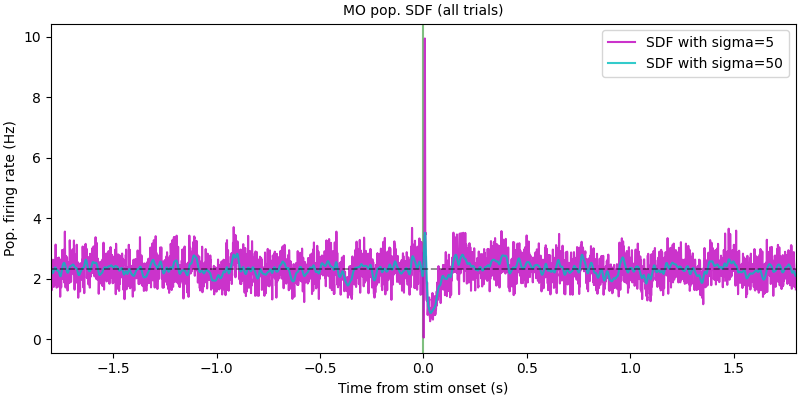

In [89]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
ax.axvline(0, color='g', alpha=0.5)
ax.plot(sdftimex, sdf_short, color='m', linewidth=1.5, alpha=0.8, label='SDF with sigma=5')
ax.plot(sdftimex, sdf_long, color='c', linewidth=1.5, alpha=0.8, label='SDF with sigma=50')
ax.axhline(fspont_sh, color='k', linewidth=1.2, linestyle='dashed', alpha=0.5)
ax.set_xlim(-1.8, 1.8)
ax.set_title('{} pop. SDF (all trials)'.format(regi))
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Pop. firing rate (Hz)')
ax.legend()

### Get 1st peak amplitude

In [29]:
search_window = [0.002, 0.025]
# thresh = fspont_sh * 1.25
thresh = fspont_sh + (3 * fstd_sh)
tinds = np.nonzero((sdftimex > search_window[0]) & (sdftimex < search_window[1]))[0]

peak1, p1props = signal.find_peaks(sdf_short[tinds], height=thresh)
maxind = np.argmax(p1props['peak_heights'])
peak1maxtime = sdftimex[tinds[peak1[maxind]]]
peak1max = p1props['peak_heights'][maxind]

<IPython.core.display.Javascript object>


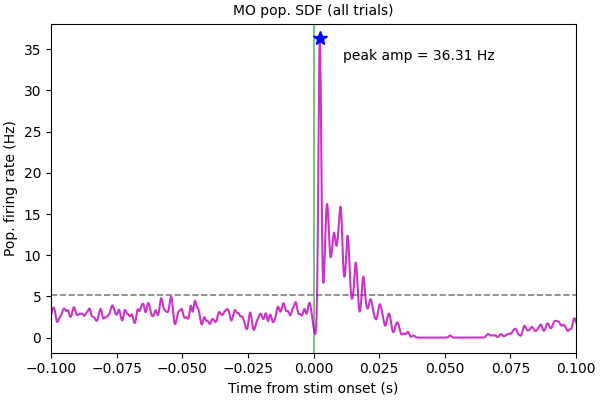

Text(0, 0.5, 'Pop. firing rate (Hz)')

In [30]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.axvline(0, color='g', alpha=0.5)
ax.axhline(thresh, color='k', linewidth=1.2, linestyle='dashed', alpha=0.5)
ax.plot(sdftimex, sdf_short, color='m', linewidth=1.5, alpha=0.8)

## Plot all peaks found ##
# for ii, pk1ind in enumerate(peak1):
#     ptime = sdftimex[tinds[pk1ind]]
#     pamp = p1props['peak_heights'][ii]
#     ax.scatter(ptime, pamp, color='b', marker='*', s=50)

## Plot max peak ##
ax.plot(peak1maxtime, peak1max, color='b', linestyle='none', marker='*', markersize=10)
ax.annotate(
    'peak amp = {:.2f} Hz'.format(peak1max), xy=(0.7, 0.9), xycoords='axes fraction', ha='center', va='center'
)

ax.set_xlim(-0.1, 0.1)
ax.set_title('{} pop. SDF (all trials)'.format(regi))
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Pop. firing rate (Hz)')

### Get OFF period duration

In [64]:
search_window = [0.002, 0.4]
# thresh = fspont_l * 0.75
thresh = fspont_l - (2 * fstd_l)
tinds = np.nonzero((sdftimex > search_window[0]) & (sdftimex < search_window[1]))[0]

below_thresh = np.nonzero(sdf_long[tinds] < thresh)[0]
OFFstart = sdftimex[tinds[below_thresh[0]]]
if len(np.nonzero(np.diff(below_thresh) > 1)[0]) > 0:
    OFFend = sdftimex[tinds[below_thresh[np.nonzero(np.diff(below_thresh) > 1)[0][0]]]]
else:
    OFFend = sdftimex[tinds[below_thresh[-1]]]

<IPython.core.display.Javascript object>


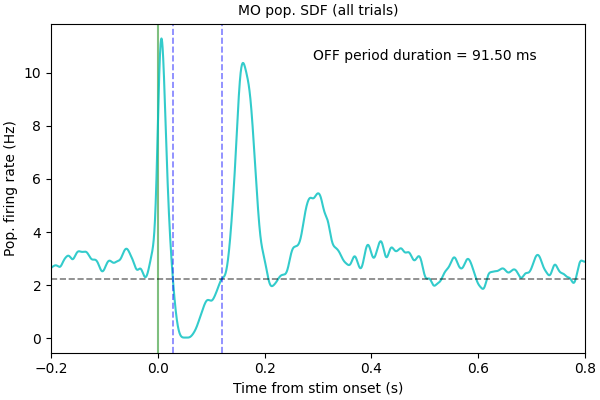

Text(0.7, 0.9, 'OFF period duration = 91.50 ms')

In [65]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.axvline(0, color='g', alpha=0.5)
ax.plot(sdftimex, sdf_long, color='c', linewidth=1.5, alpha=0.8)
ax.axhline(thresh, color='k', linewidth=1.2, linestyle='dashed', alpha=0.5)
ax.axvline(OFFstart, color='b', linewidth=1.2, linestyle='dashed', alpha=0.5)
ax.axvline(OFFend, color='b', linewidth=1.2, linestyle='dashed', alpha=0.5)
ax.set_xlim(-0.2, 0.8)
ax.set_title('{} pop. SDF (all trials)'.format(regi))
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Pop. firing rate (Hz)')
ax.annotate(
    'OFF period duration = {:.2f} ms'.format((OFFend-OFFstart) * 1E3), xy=(0.7, 0.9), xycoords='axes fraction',
    ha='center', va='center'
)

### Get 2nd peak amplitude

In [41]:
search_window = [0.075, 0.3]
# thresh = fspont_l * 1.25
thresh = fspont_l + (3 * fstd_l)
tinds = np.nonzero((sdftimex > search_window[0]) & (sdftimex < search_window[1]))[0]

peak2, p2props = signal.find_peaks(sdf_long[tinds], height=thresh)
maxind = np.argmax(p2props['peak_heights'])
peak2maxtime = sdftimex[tinds[peak2[maxind]]]
peak2max = p2props['peak_heights'][maxind]

<IPython.core.display.Javascript object>


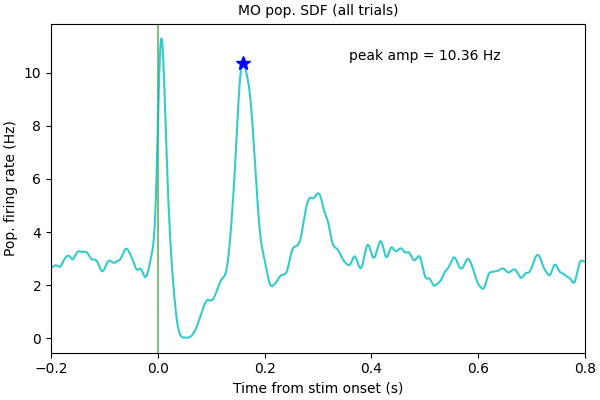

Text(0, 0.5, 'Pop. firing rate (Hz)')

In [42]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.axvline(0, color='g', alpha=0.5)
ax.plot(sdftimex, sdf_long, color='c', linewidth=1.5, alpha=0.8)

## Plot all peaks found ##
# for ii, pk2ind in enumerate(peak2):
#     ptime = sdftimex[tinds[pk2ind]]
#     pamp = p2props['peak_heights'][ii]
#     ax.scatter(ptime, pamp, color='b', marker='*', s=50)

## Plot max peak ##
ax.plot(peak2maxtime, peak2max, color='b', linestyle='none', marker='*', markersize=10)
ax.annotate(
    'peak amp = {:.2f} Hz'.format(peak2max), xy=(0.7, 0.9), xycoords='axes fraction', ha='center', va='center'
)

ax.set_xlim(-0.2, 0.8)
ax.set_title('{} pop. SDF (all trials)'.format(regi))
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Pop. firing rate (Hz)')

### To run all mice